In [4]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Point to the parent folder (KALMAN-HESTON-FILTER)
current_dir = Path.cwd()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

# Now Python sees "model" as a valid package
from model.kalman_heston_filter import kalman_like_heston_filter, estimate_params_qmle
from model.heston_mod import heston_DGP
from simulation.sim_heston_kalman import plot_heston_vs_kalman

## Initialization

In [5]:
# True parameters for the simulated Heston model (unknown in estimation):
true_params = {
    "alpha": 0.1,
    "beta": 0.9, 
    "gamma": 0.3,
    "delta": 0.2
}
T = 1000           # Number of observations for estimation.
burn_in = 100      # Burn-in period.

# Arbitrary diffusion starting value (since we don't know the true V):
V0_initial = 10.0   # Use this as initial guess for the latent state in filtering
P0_init = 0.1       # Initial filtering uncertainty

## Heston model DGP

In [17]:
# Simulate the Heston model (the "real" data)
noise_t = {'df': 2.5}
noise_par = {'alpha': 2.5}

V_series_norm, y_series_norm = heston_DGP(T, **true_params, V0=V0_initial, seed=42, noise_dist='normal', burn_in=burn_in)
V_series_t, y_series_t       = heston_DGP(T, **true_params, V0=V0_initial, seed=42, noise_dist='t', noise_params=noise_t, burn_in=burn_in)
V_series_par, y_series_par   = heston_DGP(T, **true_params, V0=V0_initial, seed=42, noise_dist='pareto', noise_params=noise_par, burn_in=burn_in)

## Estimation 
### 1. QMLE

In [22]:
# QMLE Estimation: Start with an initial guess reflecting a diffusion process.
init_guess = np.array([0.5, 0.5, 0.5, 0.5])
bounds = [
    (1e-8, None),      # alpha >= 0
    (1e-8, 1 - 1e-8),  # 0 < beta < 1
    (1e-8, None),      # gamma >= 0
    (1e-8, None)       # delta >= 0
]

result_norm = estimate_params_qmle(y_series_norm, V0=V0_initial, P0=P0_init, init_params=init_guess)
result_t    = estimate_params_qmle(y_series_t, V0=V0_initial, P0=P0_init, init_params=init_guess)
result_par  = estimate_params_qmle(y_series_par, V0=V0_initial, P0=P0_init, init_params=init_guess)

estimated_params_norm = result_norm.x
estimated_params_t    = result_t.x
estimated_params_par  = result_par.x

In [23]:
print(f"True parameters:     {list(true_params.values())}")
print(f"Normal distribution: {estimated_params_norm}")
print(f"t-distribution:      {estimated_params_t}")
print(f"Pareto distribution: {estimated_params_par}")

True parameters:     [0.1, 0.9, 0.3, 0.2]
Normal distribution: [0.12660115 0.87857984 0.35029674 0.14560793]
t-distribution:      [0.40719219 0.45153378 0.32851955 0.3022408 ]
Pareto distribution: [0.11812652 0.87805345 0.27884361 0.11404195]


## Kalman-like Heston filter

In [24]:
# Now use the estimated parameters in the Kalman filter
V_pred_norm, P_pred_norm, V_filt_norm, P_filt_norm = kalman_like_heston_filter(y_series_norm, *estimated_params_norm, V0=V0_initial, P0=P0_init)
V_pred_t, P_pred_t, V_filt_t, P_filt_t = kalman_like_heston_filter(y_series_t, *estimated_params_t, V0=V0_initial, P0=P0_init)
V_pred_par, P_pred_par, V_filt_par, P_filt_par = kalman_like_heston_filter(y_series_par, *estimated_params_par, V0=V0_initial, P0=P0_init)

## Plot

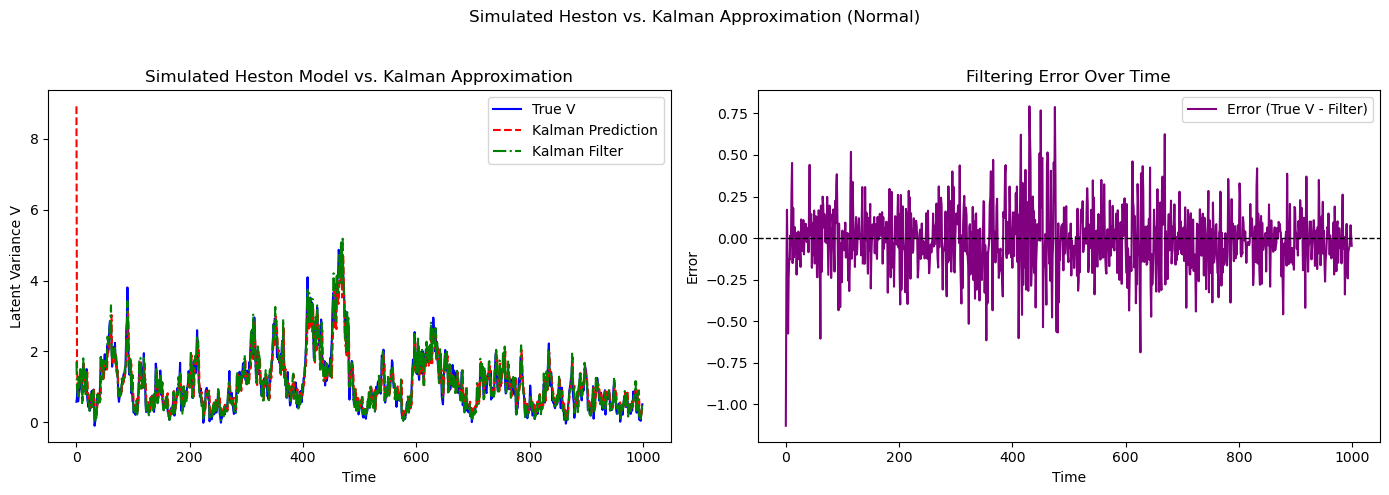

In [25]:
# Plot the simulated Heston process vs. the Kalman approximation 
plot_heston_vs_kalman(V_series_norm, V_pred_norm, V_filt_norm, title="Simulated Heston vs. Kalman Approximation (Normal)")

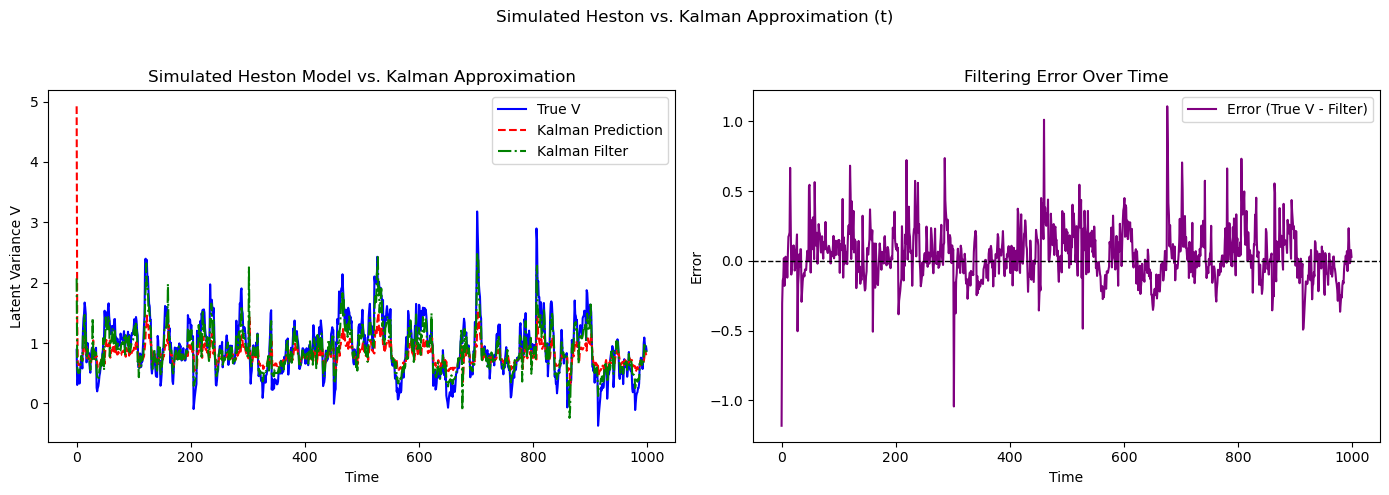

In [26]:
# Plot the simulated Heston process vs. the Kalman approximation 
plot_heston_vs_kalman(V_series_t, V_pred_t, V_filt_t, title="Simulated Heston vs. Kalman Approximation (t)")

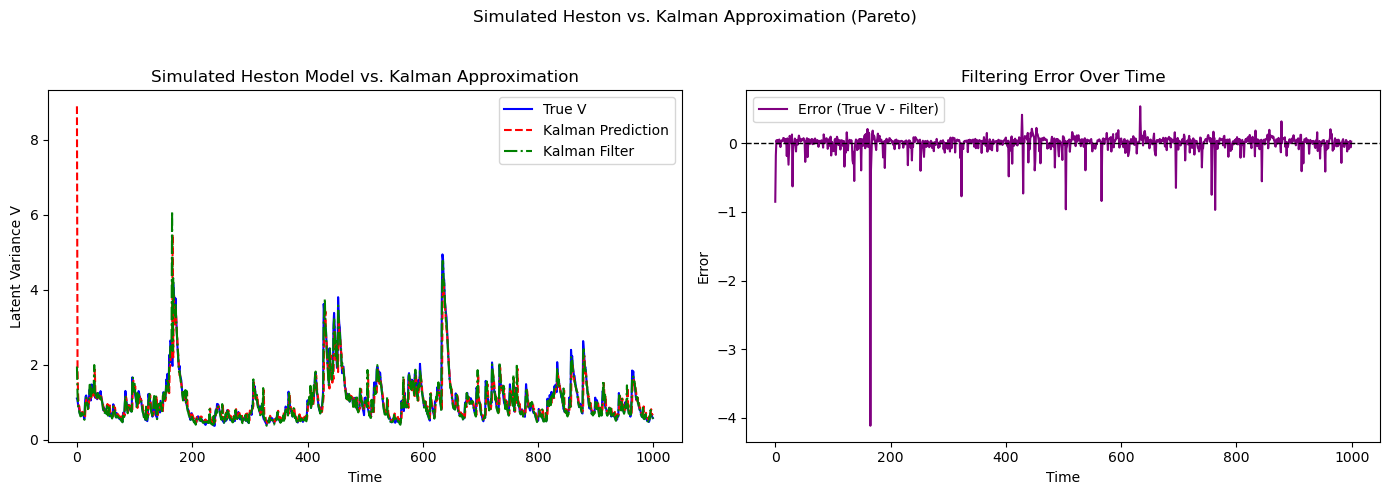

In [27]:
# Plot the simulated Heston process vs. the Kalman approximation 
plot_heston_vs_kalman(V_series_par, V_pred_par, V_filt_par, title="Simulated Heston vs. Kalman Approximation (Pareto)")